# Geiger Analysis
### Can we detect a differential in radiation counts during flight above ground level?

We had a Geiger counter mounted in the payload bay. 
* Geiger Board Webpage: https://www.sparkfun.com/products/11345
* PSAS Github Repo: https://github.com/psas/GeigerLog

In [110]:
%matplotlib inline
import numpy
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size': 16})

t_0             = 117853569585227   # see RHNU.csv

# Find closest GPS Timestamp to Launch Detect above and convert to UTC time
# Reference: http://www.labsat.co.uk/index.php/en/gps-time-calculator
V8A8_first_data_after_t_0 = 117853610593444  # GPS TIME->UTC TIME: 1854,65831.54->19 July 2015  18:17:11 UTC
MSL_0           = 1386

# Find Matching Geiger Log Timestamp to GPS Launch Detect Timestamp
# 2015-07-19 18:17:11,1437329831,2
geig_t_0        = 1437329831

#Find closest FC Timestamp for Apogee
#t_apog         = 117885061671546
#t_apog         = t_apog - t_0
#t_apog         = t_apog / 1e9

# Get GPS vectors
v8_columns     = numpy.loadtxt("geigeranalysis/V8A8.csv", delimiter=',', unpack=True)

v8_timestamp   = v8_columns[1]
MSL_Altitude   = v8_columns[9]

v8_timestamp   = numpy.subtract(v8_timestamp, t_0)
v8_timestamp   = numpy.divide(v8_timestamp, 1e9)

# Get Geiger vectors
geig_columns   = numpy.loadtxt("geigeranalysis/geiger-4.csv", delimiter=',', unpack=True,usecols=[1,2])

geig_timestamp = geig_columns[0]
geig_counts    = geig_columns[1]

geig_timestamp = numpy.subtract(geig_timestamp, geig_t_0 )

# Rocket starts on the ground
AGL_Altitude   = numpy.subtract(MSL_Altitude, MSL_0)
AGL_A_max      = numpy.amax(AGL_Altitude)

# Ok, now we have some datapoints below ground...that is silly.
for a in range(len(AGL_Altitude)):
    if AGL_Altitude[a]<0:
        AGL_Altitude[a]=0

# Create an accumulation vector
geig_accumulated = []
geig_accumulated.append(geig_counts[0])
for t in range(len(geig_timestamp)):
    if t>0:
        geig_accumulated.append(geig_accumulated[t-1] + geig_counts[t])


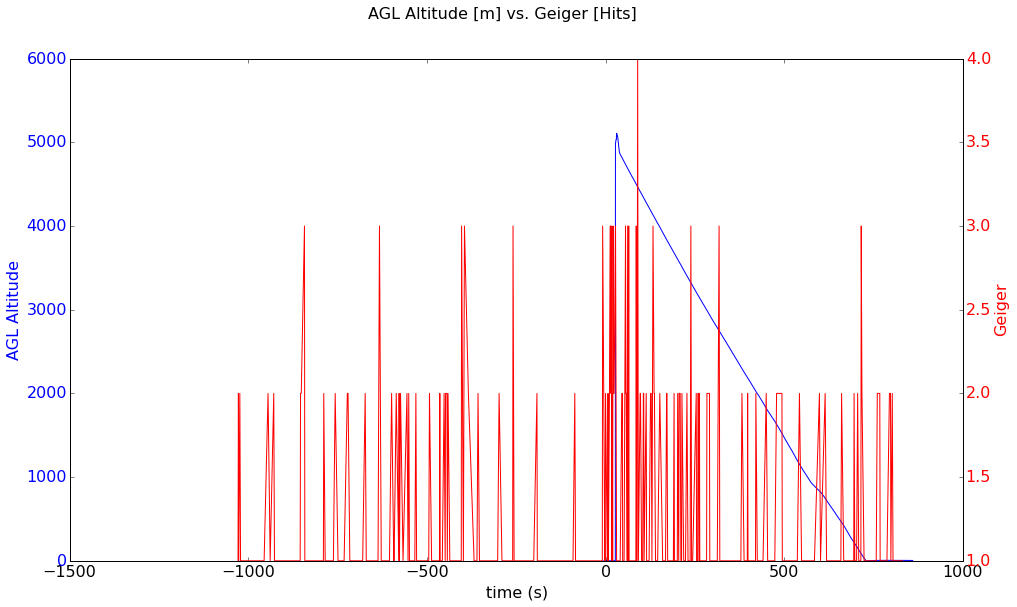

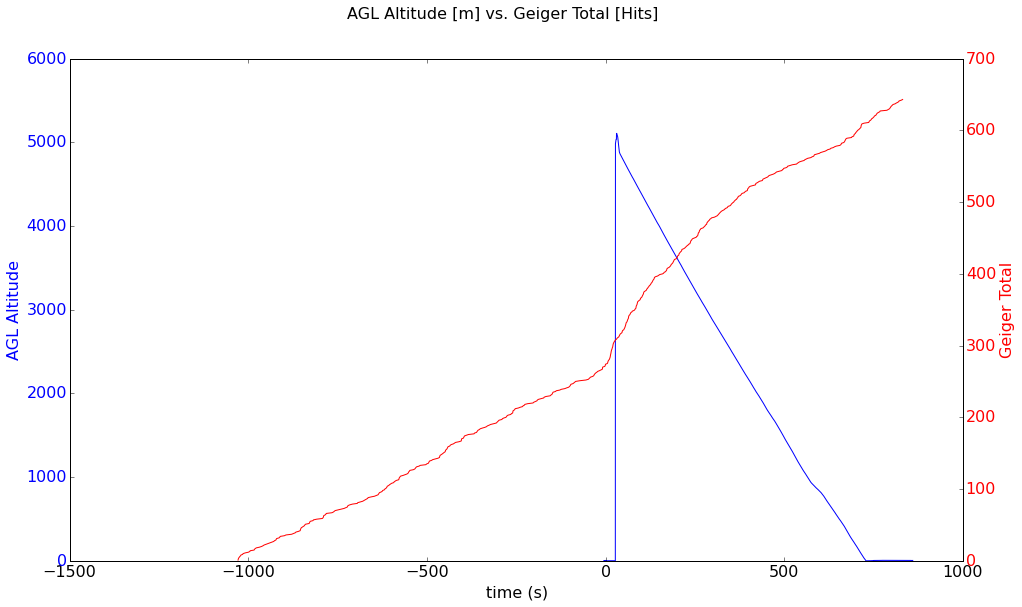

In [111]:

# Geiger Instantaneous Plot
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(v8_timestamp, AGL_Altitude , 'b-')
ax1.set_xlabel('time (s)')

ax1.set_ylabel('AGL Altitude', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(geig_timestamp, geig_counts, 'r-')
ax2.set_ylabel('Geiger', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.suptitle('AGL Altitude [m] vs. Geiger [Hits]')
plt.show()

# Geiger Accumulation Plot
fig, ax1 = plt.subplots(figsize=(16,9))
ax1.plot(v8_timestamp, AGL_Altitude , 'b-')
ax1.set_xlabel('time (s)')

ax1.set_ylabel('AGL Altitude', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(geig_timestamp, geig_accumulated, 'r-')
ax2.set_ylabel('Geiger Total', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.suptitle('AGL Altitude [m] vs. Geiger Total [Hits]')
plt.show()    

In [112]:
# Correlation

def AGL_interp(secs):
    index_high = numpy.searchsorted(v8_timestamp,secs)
    if(index_high > 0):
        index_low  = index_high -1
    else:
        raise
    return((AGL_Altitude[index_high]+AGL_Altitude[index_low])/2)
    
# Create a new AGL Altitude vector, resampled by the Geiger Time Indices
AGL_resamp  = []
for t in range(len(geig_timestamp)):
    if(geig_timestamp[t]<0):
        AGL_resamp.append(0)
    else:
        AGL_resamp.append(AGL_interp(geig_timestamp[t]))

if len(geig_counts) != len(AGL_resamp):
    raise
    
corr, p = scipy.stats.pearsonr(geig_counts, AGL_resamp)

print("The correlation (altitude vs. radiation) is: " + str(round(corr * 100, 3)) + "% with a p-value of: " + str(round(p,3)) + " ",end="",flush=True )

if(p < 0.05):
    print("(Significant)")


The correlation (altitude vs. radiation) is: 10.728% with a p-value of: 0.015 (Significant)


## Comments

* This is a very weak positive correlation at 10%...

## Questions

* Does the measurement change when the Nosecone disconnects in that the ground level and apogee measurements are not consistent?
